<h1 style="color: white; background-color: green;">Sentiment Analysis for Amazon Reviews</h1>

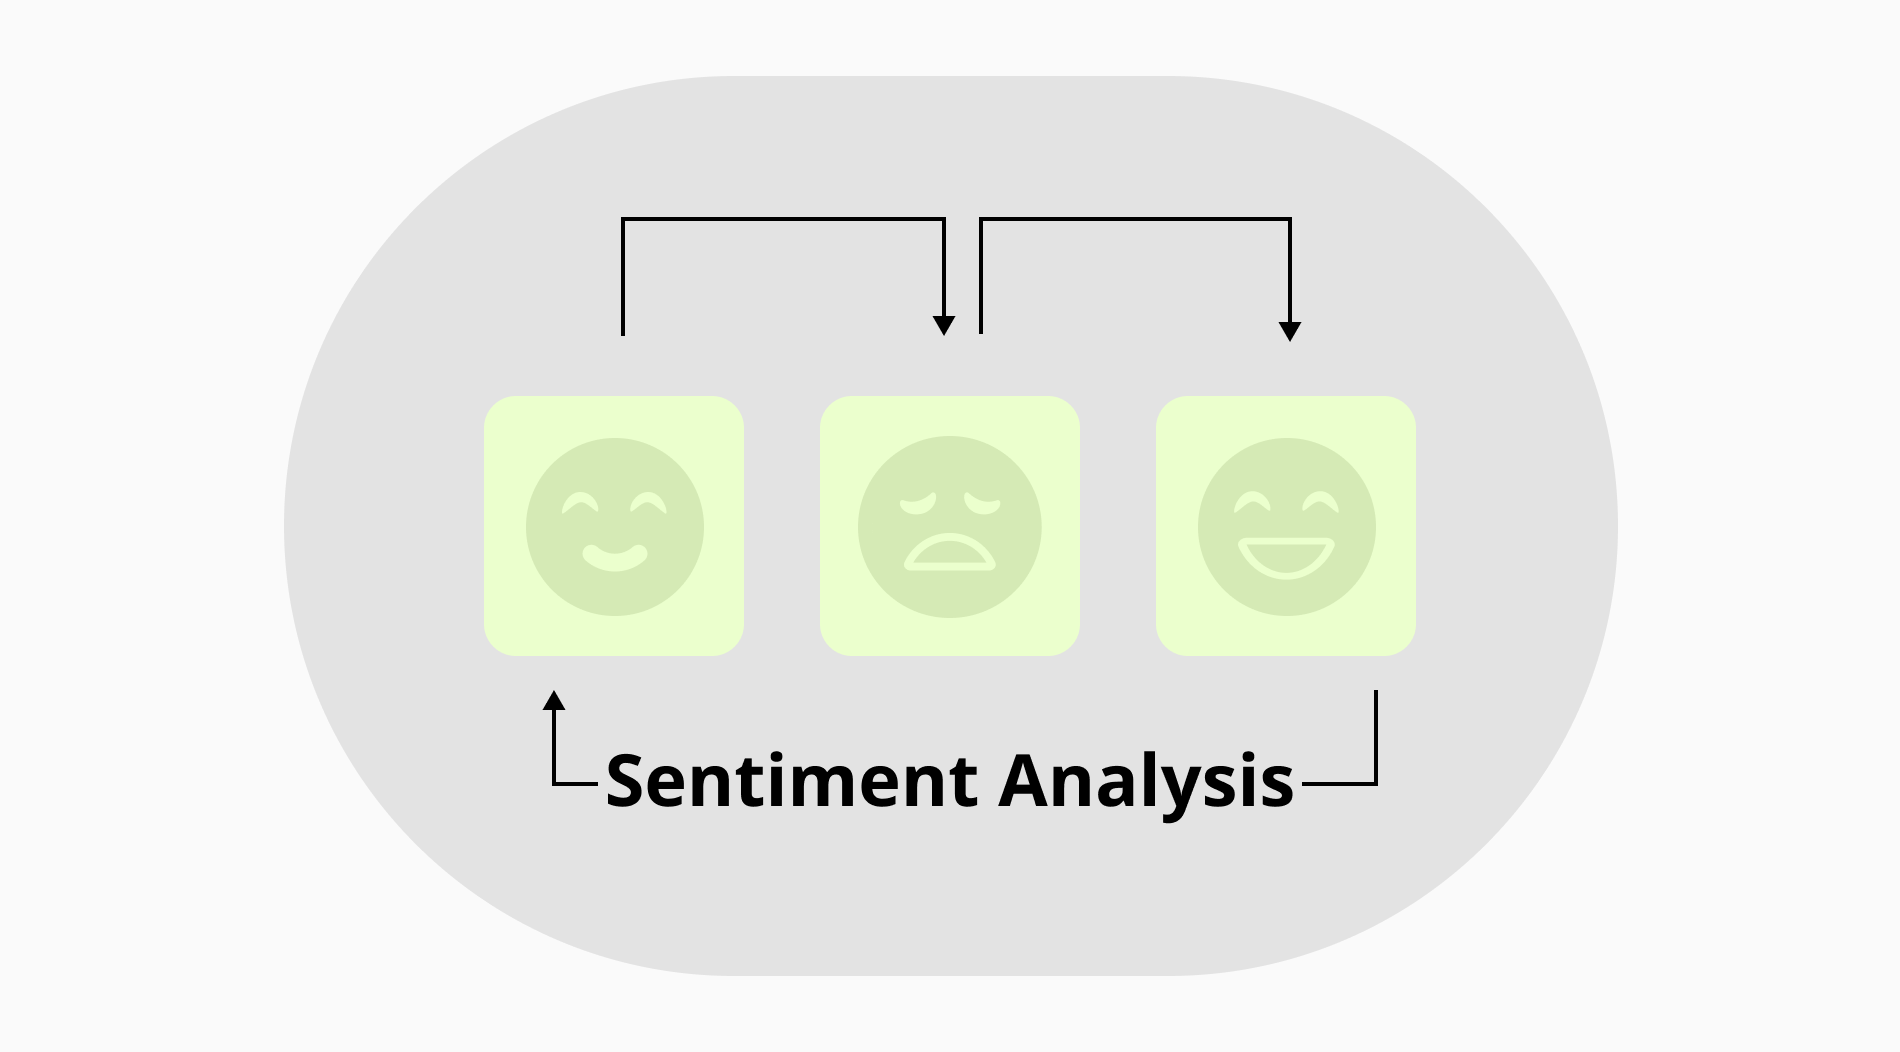

<h2 style="color: white; background-color: green;">Project Overview</h2>

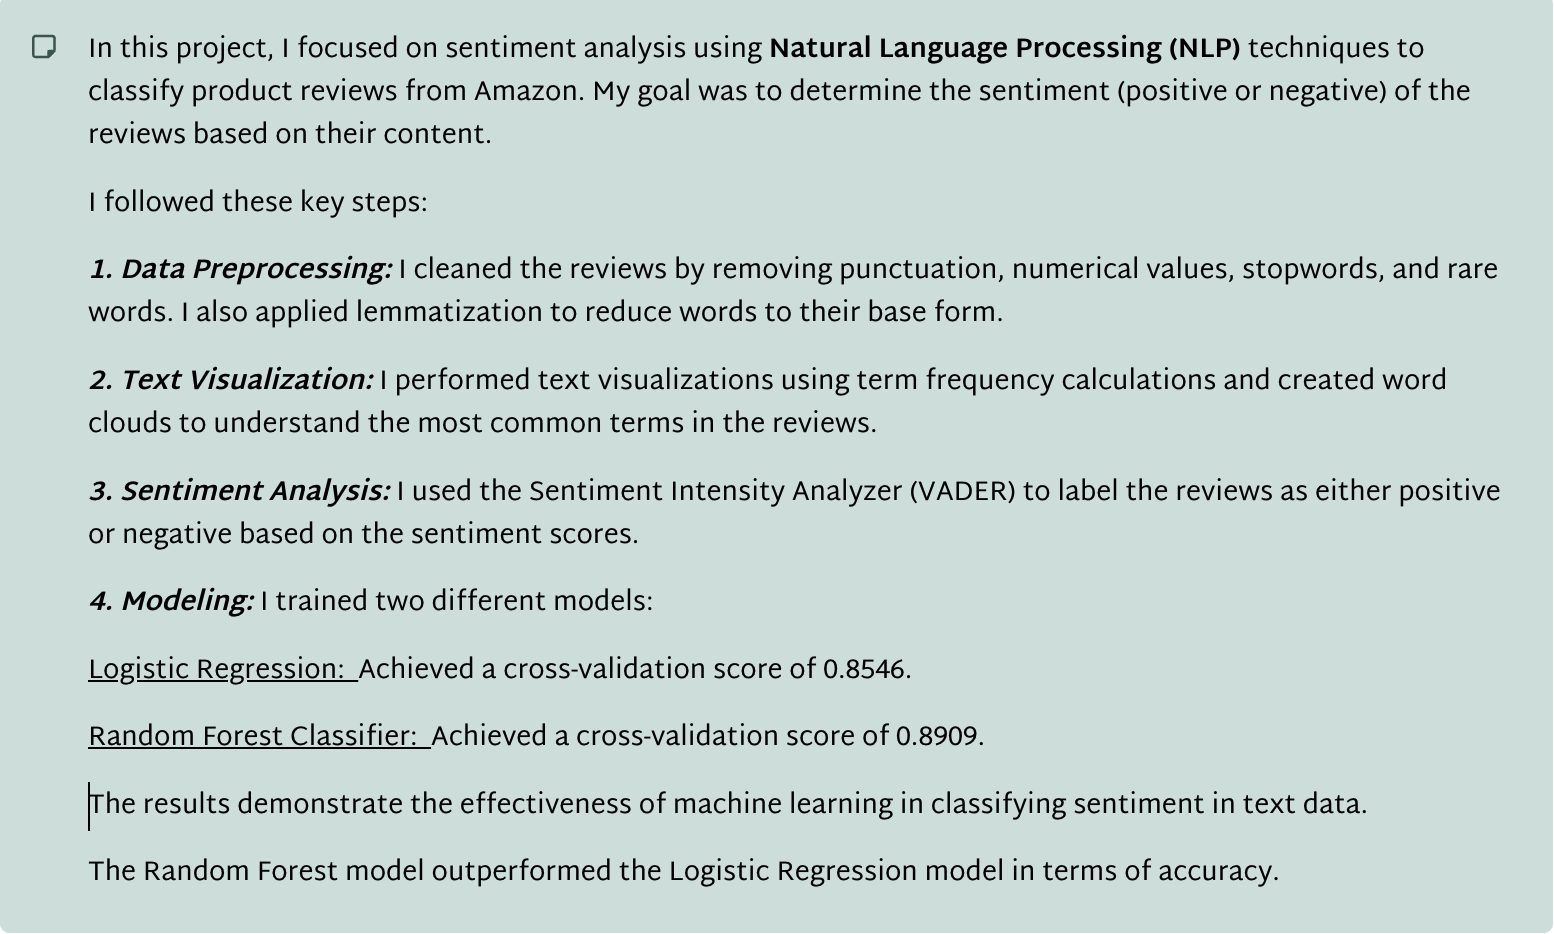

<h2 style="color: white; background-color: green;">Business Problem</h2>

Kozmos, which focuses on home textiles and daily clothing productions sold through Amazon, aims to increase its sales by analyzing customer reviews and improving its products based on received complaints. In line with this goal, sentiment analysis will be performed on the reviews, and the labeled data will be used to create a classification model.

<h2 style="color: white; background-color: green;">Dataset Story</h2>

The dataset consists of reviews made for a specific product group, including variables such as the review title, star rating, and the number of people who found the review helpful.

<h2 style="color: white; background-color: green;">Required Libraries</h2>

In [42]:
!pip install nltk
!pip install scikit-learn
!pip install pandas
!pip install numpy
!pip install pillow
!pip install textblob
!pip install wordcloud
!pip install scikit-surprise

In [7]:
from warnings import filterwarnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from surprise.model_selection import train_test_split
from textblob import Word, TextBlob
from wordcloud import WordCloud
from sklearn.metrics import classification_report
from nltk.stem import WordNetLemmatizer
import warnings
import nltk
import os

# Set the NLTK data path specifically for Kaggle
nltk_data_dir = "/kaggle/working/nltk_data"
os.makedirs(nltk_data_dir, exist_ok=True)
nltk.data.path.append(nltk_data_dir)

# Force install all required packages
nltk.download("stopwords", download_dir=nltk_data_dir, quiet=True)
nltk.download("punkt", download_dir=nltk_data_dir, quiet=True)
nltk.download("wordnet", download_dir=nltk_data_dir, quiet=True)
nltk.download("omw-1.4", download_dir=nltk_data_dir, quiet=True)

# Suppress warnings
filterwarnings('ignore')
warnings.filterwarnings("ignore", category=UserWarning, module='nltk.twitter')

NOTE: WordNet Installation Issue Solution

In the Kaggle environment, there might be issues accessing NLTK's WordNet database. 
The following code block is used to solve this problem:

1. WordNet is manually downloaded from the GitHub NLTK repository
2. The downloaded ZIP file is extracted to the correct location
3. The new WordNet directory is introduced to NLTK

If you're getting this error:
Resource 'corpora/wordnet' not found. Please use the NLTK Downloader to obtain the resource.

The code block below will solve the issue.

In [8]:
import nltk
import os
import urllib.request
import zipfile
from pathlib import Path

# Set the NLTK data directory for Kaggle
nltk_data_dir = Path("/kaggle/working/nltk_data")
corpora_dir = nltk_data_dir / "corpora"

# Create the necessary directories
corpora_dir.mkdir(parents=True, exist_ok=True)

# Manually download WordNet
wordnet_url = "https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/wordnet.zip"
wordnet_zip = corpora_dir / "wordnet.zip"

print("Downloading WordNet...")
try:
    urllib.request.urlretrieve(wordnet_url, wordnet_zip)
    print("Download complete.")
    
    # Unzip the ZIP file
    with zipfile.ZipFile(wordnet_zip, 'r') as zip_ref:
        zip_ref.extractall(corpora_dir)
    print("The ZIP file is extracted.")
    
    # Delete the ZIP file
    wordnet_zip.unlink()
    print("The ZIP file is deleted.")
    
except Exception as e:
    print(f"Download or open error: {str(e)}")

# Add the path to NLTK
nltk.data.path.insert(0, str(nltk_data_dir))

# Check it
print("\nFile check:")
wordnet_dir = corpora_dir / "wordnet"
print(f"Is the WordNet directory present: {wordnet_dir.exists()}")
if wordnet_dir.exists():
    print("WordNet files:")
    for file in wordnet_dir.glob("*"):
        print(f"- {file.name}")

# Test it
try:
    from nltk.stem import WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    test_word = "running"
    result = lemmatizer.lemmatize(test_word, pos="v")
    print(f"\nThe lemmatization test is successful: '{test_word}' -> '{result}'")
except Exception as e:
    print(f"\nLemmatization error: {str(e)}")

Download complete.
The ZIP file is extracted.
The ZIP file is deleted.

File check:
Is the WordNet directory present: True
WordNet files:
- index.verb
- verb.exc
- adv.exc
- index.sense
- index.adj
- adj.exc
- noun.exc
- README
- data.noun
- data.adv
- index.adv
- lexnames
- LICENSE
- cntlist.rev
- citation.bib
- index.noun
- data.adj
- data.verb

The lemmatization test is successful: 'running' -> 'run'


<h2 style="color: white; background-color: green;">Text Preprocessing</h2>

In [9]:
df = pd.read_csv("/kaggle/input/kozmos/kozmos.csv")
df.head()

,Star,HelpFul,Title,Review
0,5,0,looks great,Happy with it
1,5,0,Pattern did not align between the two panels.,Good quality material however the panels are m...
2,5,0,Imagery is stretched. Still fun.,Product was fun for bedroom windows.<br />Imag...
3,5,0,Que se ven elegantes muy finas,Lo unico que me gustaria es que sean un poco ...
4,5,0,Wow great purchase,Great bang for the buck I can't believe the qu...


In [10]:
df.shape

(5611, 4)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5611 entries, 0 to 5610
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Star     5611 non-null   int64 
 1   HelpFul  5611 non-null   int64 
 2   Title    5559 non-null   object
 3   Review   5593 non-null   object
dtypes: int64(2), object(2)
memory usage: 175.5+ KB


<h3 style="color: white; background-color: green;">Normalizing Case Folding</h3>

In [12]:
df['Review'] = df['Review'].str.lower()
df['Review']

0                                           happy with it
1       good quality material however the panels are m...
2       product was fun for bedroom windows.<br />imag...
3        lo unico que me gustaria es que sean un poco ...
4       great bang for the buck i can't believe the qu...
                              ...                        
5606    great product for reasonable money.  delivered...
5607             color is way off and panels do not match
5608    these are great for my studio as they compleme...
5609    brought out the beauty in kids room. they love...
5610    very cute curtains in my sons room! thick enou...
Name: Review, Length: 5611, dtype: object

<h3 style="color: white; background-color: green;">Removing Punctuation</h3>

In [13]:
df['Review'] = df['Review'].str.replace('[^\w\s]', '', regex=True)
df['Review']

0                                           happy with it
1       good quality material however the panels are m...
2       product was fun for bedroom windowsbr imagery ...
3        lo unico que me gustaria es que sean un poco ...
4       great bang for the buck i cant believe the qua...
                              ...                        
5606    great product for reasonable money  delivered ...
5607             color is way off and panels do not match
5608    these are great for my studio as they compleme...
5609     brought out the beauty in kids room they love it
5610    very cute curtains in my sons room thick enoug...
Name: Review, Length: 5611, dtype: object

<h3 style="color: white; background-color: green;">Removing Numerical Values</h3>

In [14]:
df['Review'] = df['Review'] .str.replace('\d', '', regex=True)
df['Review']

0                                           happy with it
1       good quality material however the panels are m...
2       product was fun for bedroom windowsbr imagery ...
3        lo unico que me gustaria es que sean un poco ...
4       great bang for the buck i cant believe the qua...
                              ...                        
5606    great product for reasonable money  delivered ...
5607             color is way off and panels do not match
5608    these are great for my studio as they compleme...
5609     brought out the beauty in kids room they love it
5610    very cute curtains in my sons room thick enoug...
Name: Review, Length: 5611, dtype: object

<h3 style="color: white; background-color: green;">Removing Stopwords</h3>

In [15]:
sw = stopwords.words('english')

In [16]:
df['Review'] = df['Review'].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))
df["Review"]

0                                                   happy
1         good quality material however panels mismatched
2       product fun bedroom windowsbr imagery bit stre...
3       lo unico que gustaria es que sean un poco mas ...
4       great bang buck cant believe quality material ...
                              ...                        
5606    great product reasonable money delivered quick...
5607                               color way panels match
5608    great studio complement entire theme studioliv...
5609                        brought beauty kids room love
5610      cute curtains sons room thick enough keep light
Name: Review, Length: 5611, dtype: object

<h3 style="color: white; background-color: green;">Removing Rarewords</h3>

In [17]:
drops = pd.Series(' '.join(df['Review']).split()).value_counts()[-1000:]
drops

keen              1
interpretation    1
greatwould        1
percect           1
nother            1
                 ..
neato             1
decormatches      1
thx               1
pricebrid         1
studioliving      1
Name: count, Length: 1000, dtype: int64

In [18]:
df['Review'] = df['Review'].apply(lambda x: " ".join(x for x in x.split() if x not in drops))
df['Review']

0                                                   happy
1         good quality material however panels mismatched
2       product fun bedroom windowsbr imagery bit stre...
3       lo unico que gustaria es que sean un poco mas ...
4       great bang buck cant believe quality material ...
                              ...                        
5606    great product reasonable money delivered quick...
5607                               color way panels match
5608    great studio complement entire theme area phot...
5609                        brought beauty kids room love
5610      cute curtains sons room thick enough keep light
Name: Review, Length: 5611, dtype: object

<h3 style="color: white; background-color: green;">Lemmatization</h3>

In [19]:
df['Review'] = df['Review'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
df['Review']

0                                                   happy
1          good quality material however panel mismatched
2       product fun bedroom windowsbr imagery bit stre...
3       lo unico que gustaria e que sean un poco ma la...
4       great bang buck cant believe quality material ...
                              ...                        
5606    great product reasonable money delivered quick...
5607                                color way panel match
5608    great studio complement entire theme area phot...
5609                         brought beauty kid room love
5610        cute curtain son room thick enough keep light
Name: Review, Length: 5611, dtype: object

<h2 style="color: white; background-color: green;">Text Visualization</h2>

<h3 style="color: white; background-color: green;">Calculation of Term Frequencies</h3>

In [20]:
tf = df["Review"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
tf.columns = ["words", "tf"]
tf.sort_values("tf", ascending=False)

,words,tf
66,curtain,2588.0
42,look,1531.0
120,love,1453.0
104,room,1129.0
166,like,1053.0
...,...,...
2876,unwuiness,1.0
2878,enters,1.0
2879,soonbrlittle,1.0
2880,isbrbrlove,1.0


<h3 style="color: white; background-color: green;">Barplot</h3>

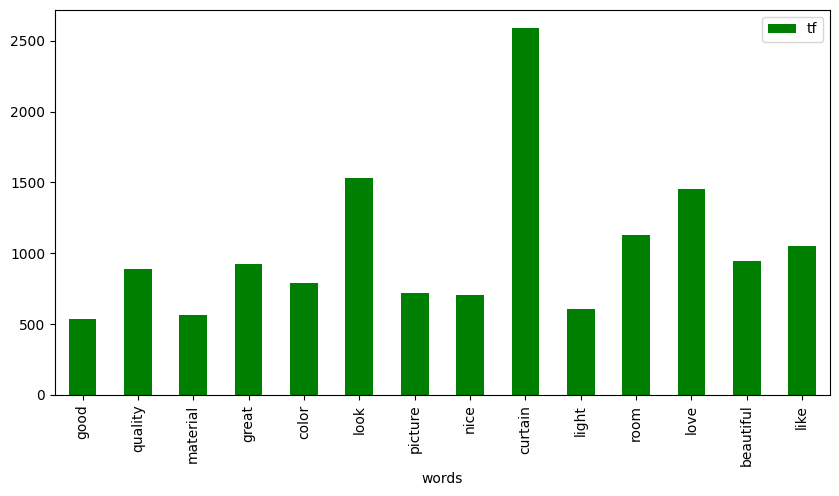

In [21]:
tf[tf["tf"] > 500].plot.bar(x="words", y="tf", color="green", figsize=(10,5))
plt.show()

<h3 style="color: white; background-color: green;">Wordcloud</h3>

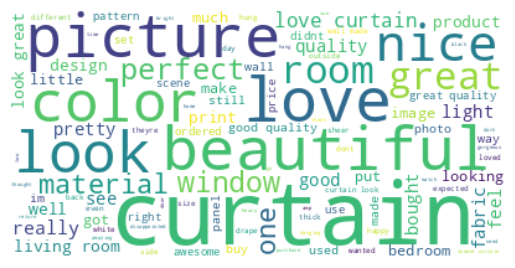

In [22]:
text = " ".join(i for i in df.Review)

wordcloud = WordCloud(max_font_size=70,
                      max_words=100,
                      background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

<h2 style="color: white; background-color: green;">Sentiment Analysis</h2>

In [23]:
df["Review"].head()

0                                                happy
1       good quality material however panel mismatched
2    product fun bedroom windowsbr imagery bit stre...
3    lo unico que gustaria e que sean un poco ma la...
4    great bang buck cant believe quality material ...
Name: Review, dtype: object

In [24]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

df["Review"][0:10].apply(lambda x: sia.polarity_scores(x))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


0    {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...
1    {'neg': 0.0, 'neu': 0.633, 'pos': 0.367, 'comp...
2    {'neg': 0.0, 'neu': 0.647, 'pos': 0.353, 'comp...
3    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
4    {'neg': 0.0, 'neu': 0.517, 'pos': 0.483, 'comp...
5    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
6    {'neg': 0.0, 'neu': 0.631, 'pos': 0.369, 'comp...
7    {'neg': 0.0, 'neu': 0.578, 'pos': 0.422, 'comp...
8    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
9    {'neg': 0.0, 'neu': 0.772, 'pos': 0.228, 'comp...
Name: Review, dtype: object

In [25]:
df["Polarity_Score"] = df["Review"][0:10].apply(lambda x: sia.polarity_scores(x)["compound"])
df["Polarity_Score"]

0       0.5719
1       0.4404
2       0.7184
3       0.0000
4       0.9042
         ...  
5606       NaN
5607       NaN
5608       NaN
5609       NaN
5610       NaN
Name: Polarity_Score, Length: 5611, dtype: float64

In [26]:
df["Sentiment_Label"] = df["Review"].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")
df["Sentiment_Label"]

0       pos
1       pos
2       pos
3       neg
4       pos
       ... 
5606    pos
5607    neg
5608    pos
5609    pos
5610    pos
Name: Sentiment_Label, Length: 5611, dtype: object

In [27]:
df["Sentiment_Label"].value_counts()

Sentiment_Label
pos    4764
neg     847
Name: count, dtype: int64

In [28]:
df.groupby("Sentiment_Label")["Star"].mean()

Sentiment_Label
neg    3.390791
pos    4.586692
Name: Star, dtype: float64

By labeling comments with Sentiment Intensity Analyzer, the dependent variable for the comment classification machine learning model was created.


<h2 style="color: white; background-color: green;">Machine Learning Preparation</h2>

In [29]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(df["Review"],
                                                   df["Sentiment_Label"],
                                                   random_state=42)

<h3 style="color: white; background-color: green;">Creating a TF-IDF Vectorizer</h3>

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()

<h3 style="color: white; background-color: green;">Vectorizing the Training Data</h3>

In [31]:
X_train_tfidf = tfidf.fit_transform(train_x)
X_test_tfidf = tfidf.transform(test_x)

<h2 style="color: white; background-color: green;">Modeling (Logistic Regression)</h2>

<h3 style="color: white; background-color: green;">Model Training</h3>

In [32]:
log_model = LogisticRegression()
log_model.fit(X_train_tfidf, train_y)

LogisticRegression()

<h3 style="color: white; background-color: green;">Model Performance</h3>

In [33]:
y_pred = log_model.predict(X_test_tfidf)
print("Model Performance:")
print(classification_report(y_pred, test_y))

Model Performance:
              precision    recall  f1-score   support

         neg       0.33      0.90      0.49        82
         pos       0.99      0.89      0.94      1321

    accuracy                           0.89      1403
   macro avg       0.66      0.89      0.71      1403
weighted avg       0.95      0.89      0.91      1403



In [35]:
log_score = cross_val_score(log_model, X_test_tfidf, test_y, cv=5).mean()
log_score

0.8546034570411795

<h3 style="color: #00FF00;">Selecting a random comment and making a prediction</h3>

In [36]:
random_review = df["Review"].sample(1).iloc[0]
new_review = tfidf.transform([random_review])
pred = log_model.predict(new_review)

print(f"Review: {random_review} \nPrediction: {pred}")

Review: nice childroom curtain son love 
Prediction: ['pos']


<h2 style="color: white; background-color: green;">Modeling (Random Forest)</h2>

In [38]:
rf_model = RandomForestClassifier().fit(X_train_tfidf, train_y)
rf_score = cross_val_score(rf_model, X_test_tfidf, test_y, cv=5, n_jobs=-1).mean()
rf_score

0.8909532282663954

<h2 style="color: white; background-color: green;">Model Performance Comparison and Evaluation</h2>

In [39]:
print(f"Logistic Regression Score: {log_score:.4f}")
print(f"Random Forest Score: {rf_score:.4f}")

if log_score > rf_score:
    print("Logistic Regression performed better.")
elif log_score < rf_score:
    print("Random Forest performed better.")
else:
    print("Both models performed equally well.")

Logistic Regression Score: 0.8546
Random Forest Score: 0.8910
Random Forest performed better.


In [40]:
diff = abs(log_score - rf_score)
percentage_diff = (diff / max(log_score, rf_score)) * 100
print(f"Performance difference: {percentage_diff:.2f}%")

Performance difference: 4.08%
